In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

In [2]:
import random
import torch


class Net(torch.nn.Module):
    def __init__(self,A):
        """
        In the constructor we construct three nn.Linear instances that we will use
        in the forward pass.
        """
        super(Net, self).__init__()
        self.X=torch.eye(A.size()[0])
        self.lin=nn.Linear(A.size()[0], A.size()[0])
        self.B=A+torch.eye(A.size()[0])
        self.D=(torch.diag(torch.sum(A,1)))
        self.D=self.D.inverse()
        self.D=self.D.sqrt()
        self.A=torch.mm(torch.mm(self.D,self.B),self.D)
        self.W0=nn.Parameter(torch.randn(A.size()[0], 10,requires_grad=True))
        self.W1=nn.Parameter(torch.randn(10, 2,requires_grad=True))
    def forward(self):
        self.H=torch.relu(torch.mm(torch.mm(self.A,self.X),self.W0))

        self.H2=(torch.mm(torch.mm(self.A,self.H),self.W1))
        return self.H2
        

In [3]:
A=torch.Tensor([[0,1,0,1,0,0,0,0,0,0],
[1,0,1,0,0,0,0,0,0,0],
[0,1,0,1,0,0,0,0,0,0],
[1,0,1,0,0,0,0,0,0,0],
[0,0,0,0,0,1,0,0,0,1],
[0,0,0,0,1,0,1,0,0,0],
[0,0,0,0,0,1,0,1,0,0],
[0,0,0,0,0,0,1,0,1,0],
[0,0,0,0,0,0,0,1,0,1],
[0,0,0,0,1,0,0,0,1,0]
])



In [4]:
target=torch.tensor([1,-1,-1,-1, -1, -1, -1, -1,-1,0])

In [5]:
mask=torch.tensor([1,0, 0, 0 ,0, 0, 0, 0, 0, 1])

In [6]:
T=Net(A)

In [7]:
T.A

tensor([[0.5000, 0.5000, 0.0000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.5000, 0.5000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.5000, 0.5000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.5000, 0.0000, 0.5000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.5000, 0.5000, 0.0000, 0.0000, 0.0000,
         0.5000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.5000, 0.5000, 0.5000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.5000, 0.5000, 0.5000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.5000, 0.5000, 0.5000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.5000, 0.5000,
         0.5000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.5000, 0.0000, 0.0000, 0.0000, 0.5000,
         0.5000]])

In [8]:
T()

tensor([[-0.3586, -0.7419],
        [-0.9011, -0.1991],
        [ 0.2774, -0.7381],
        [-0.7378, -0.9516],
        [-1.6932, -3.2187],
        [-1.2574, -4.1328],
        [-0.3666, -3.2280],
        [ 0.5860, -1.0658],
        [ 0.1502, -0.1517],
        [-0.7407, -1.0564]], grad_fn=<MmBackward>)

In [9]:
[x for x in T.parameters()]


[Parameter containing:
 tensor([[ 0.0615,  0.7775, -0.1867, -1.2316,  0.7162,  0.7513, -0.2647, -0.3413,
          -0.9908, -0.7187],
         [ 1.6235, -2.0612,  0.7853, -1.8739, -0.6922, -1.3416,  1.2863, -0.8888,
          -0.8188,  0.5765],
         [-1.6501, -0.3238, -0.7138, -0.4938,  0.1524, -0.2740, -0.3199,  1.3202,
           0.0969, -0.2929],
         [ 1.2922,  0.3397, -0.8637, -1.0402,  0.7850,  0.7477,  1.7255,  1.8569,
          -1.6784, -0.6768],
         [ 0.2934,  0.1981, -0.0042,  0.6094, -1.0291,  1.4194, -1.3472, -0.6394,
           0.9073,  0.5213],
         [-1.2461, -0.5272,  0.2886, -0.9763, -0.0482, -0.3380, -0.9547, -0.4412,
           0.0346,  0.1126],
         [ 0.2691,  2.2244, -0.0755, -0.5695,  0.6678,  0.1380, -1.4748, -0.9245,
          -0.9010,  1.2342],
         [-0.9395, -0.3317,  0.9067,  0.2588,  0.1933, -0.3761, -1.5709, -0.2685,
           0.2488,  0.5366],
         [-0.1098, -1.3719,  0.9938, -0.4032,  0.6107, -1.1426, -0.2238,  0.8751,
       

In [10]:
import torch.optim as optim

criterion = torch.nn.CrossEntropyLoss(ignore_index=-1)
optimizer = optim.SGD(T.parameters(), lr=0.0001, momentum=0.9)

In [11]:
loss=criterion(T(),target)

In [12]:
def PCA(data, k=2):
 # preprocess the data
    X = (data)
    X_mean = torch.mean(X,0)
    X = X - X_mean.expand_as(X)
     # svd
    U,S,V = torch.svd(torch.t(X))
    return torch.mm(X,U[:,:k])

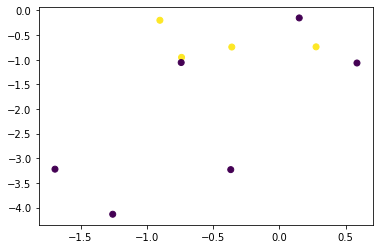

tensor(0.7254, grad_fn=<NllLossBackward>)


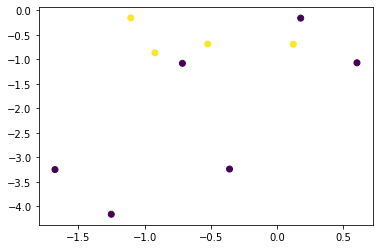

tensor(0.6532, grad_fn=<NllLossBackward>)


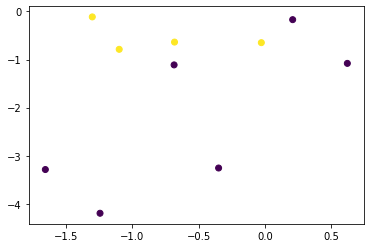

tensor(0.5873, grad_fn=<NllLossBackward>)


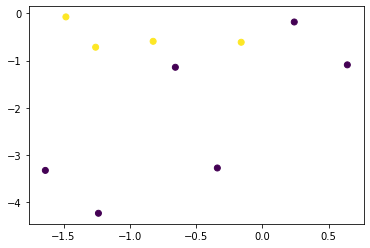

tensor(0.5322, grad_fn=<NllLossBackward>)


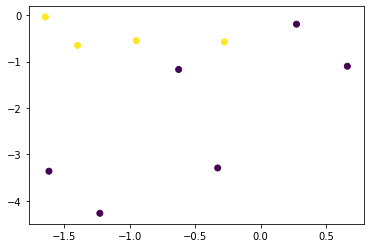

tensor(0.4858, grad_fn=<NllLossBackward>)


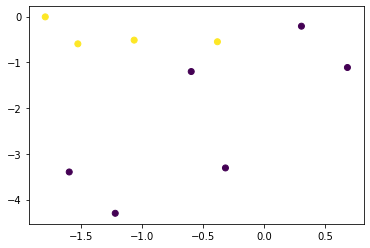

tensor(0.4461, grad_fn=<NllLossBackward>)


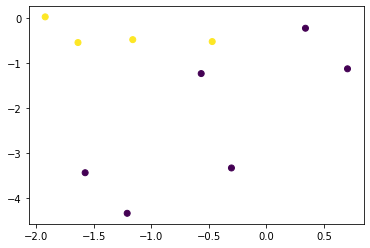

tensor(0.4122, grad_fn=<NllLossBackward>)


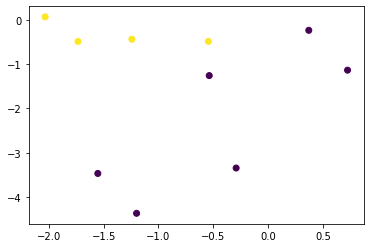

tensor(0.3830, grad_fn=<NllLossBackward>)


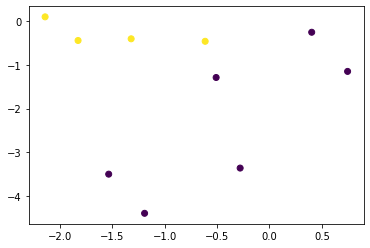

tensor(0.3571, grad_fn=<NllLossBackward>)


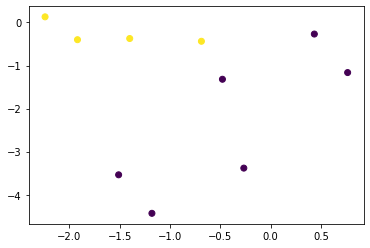

tensor(0.3325, grad_fn=<NllLossBackward>)


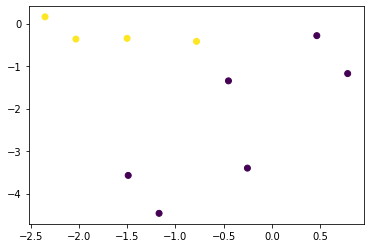

tensor(0.3082, grad_fn=<NllLossBackward>)


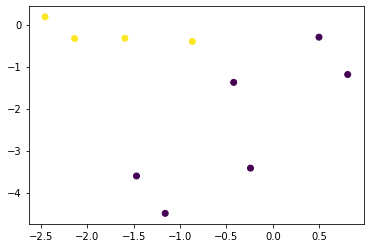

tensor(0.2868, grad_fn=<NllLossBackward>)


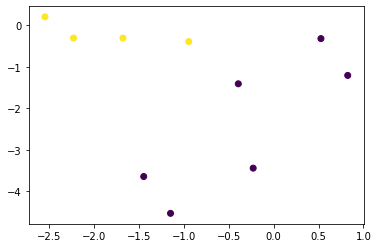

tensor(0.2678, grad_fn=<NllLossBackward>)


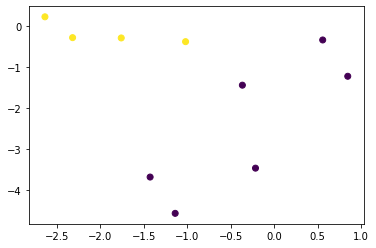

tensor(0.2508, grad_fn=<NllLossBackward>)


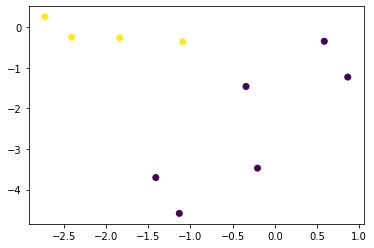

tensor(0.2356, grad_fn=<NllLossBackward>)


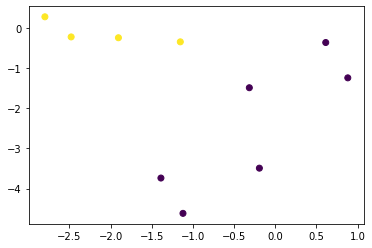

tensor(0.2218, grad_fn=<NllLossBackward>)


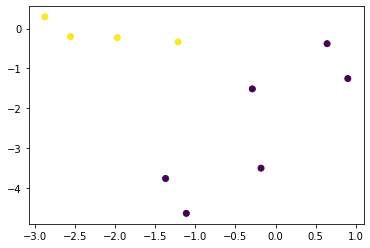

tensor(0.2093, grad_fn=<NllLossBackward>)


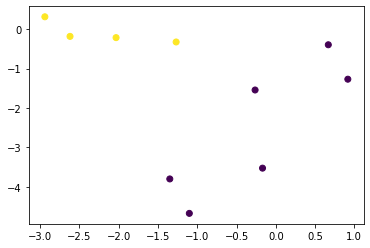

tensor(0.1980, grad_fn=<NllLossBackward>)


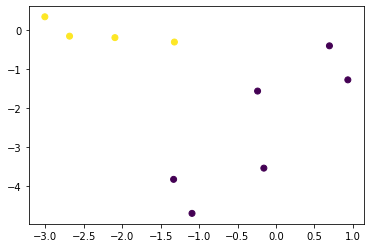

tensor(0.1876, grad_fn=<NllLossBackward>)


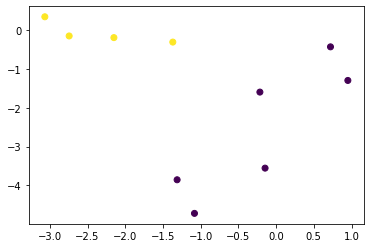

tensor(0.1781, grad_fn=<NllLossBackward>)


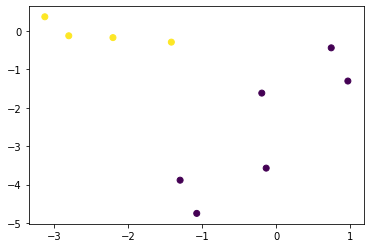

tensor(0.1696, grad_fn=<NllLossBackward>)


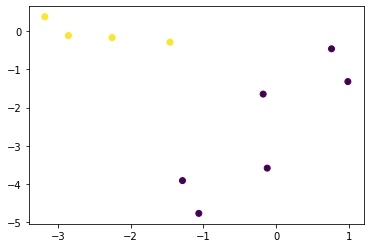

tensor(0.1622, grad_fn=<NllLossBackward>)


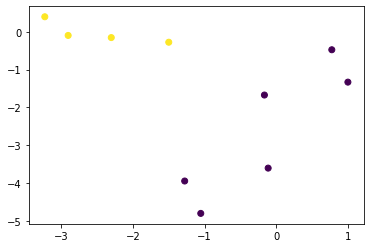

tensor(0.1553, grad_fn=<NllLossBackward>)


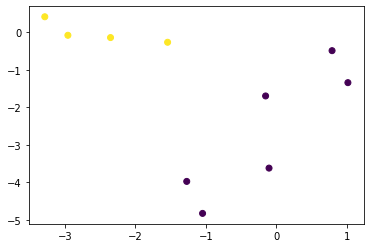

tensor(0.1488, grad_fn=<NllLossBackward>)


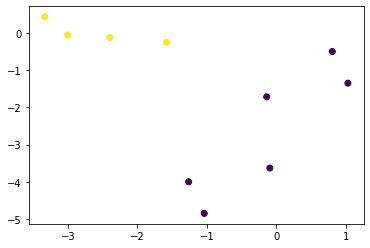

tensor(0.1428, grad_fn=<NllLossBackward>)


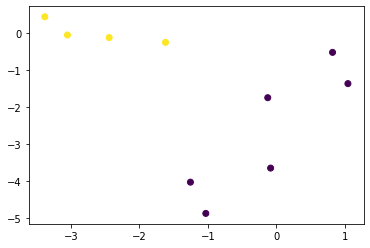

tensor(0.1372, grad_fn=<NllLossBackward>)


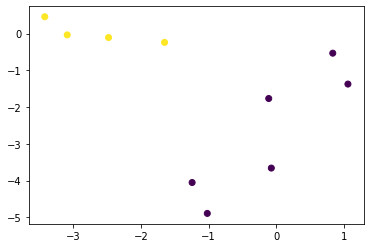

tensor(0.1320, grad_fn=<NllLossBackward>)


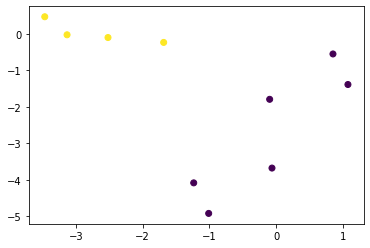

tensor(0.1270, grad_fn=<NllLossBackward>)


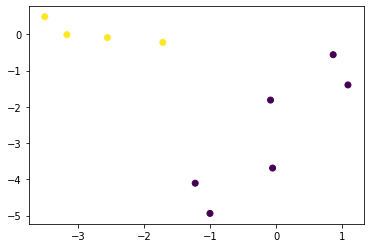

tensor(0.1224, grad_fn=<NllLossBackward>)


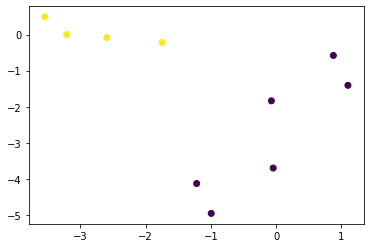

tensor(0.1180, grad_fn=<NllLossBackward>)


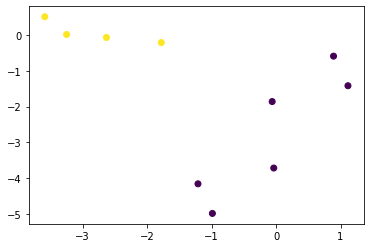

tensor(0.1139, grad_fn=<NllLossBackward>)


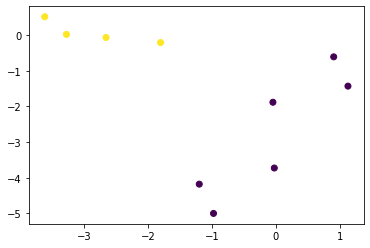

tensor(0.1099, grad_fn=<NllLossBackward>)


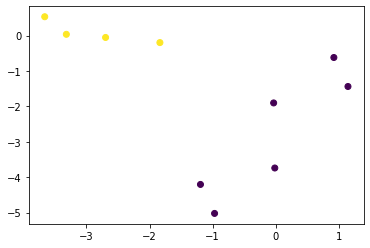

tensor(0.1062, grad_fn=<NllLossBackward>)


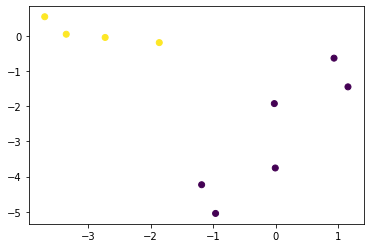

tensor(0.1027, grad_fn=<NllLossBackward>)


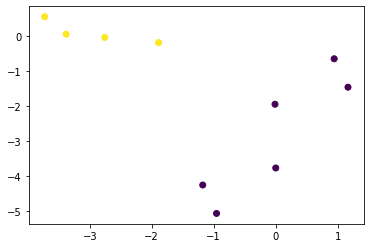

tensor(0.0994, grad_fn=<NllLossBackward>)


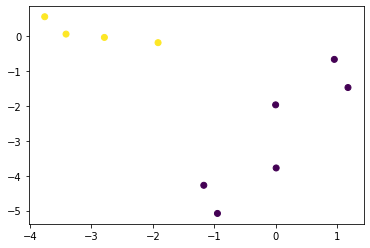

tensor(0.0963, grad_fn=<NllLossBackward>)


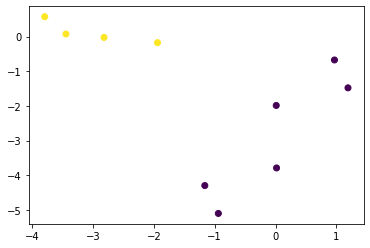

tensor(0.0933, grad_fn=<NllLossBackward>)


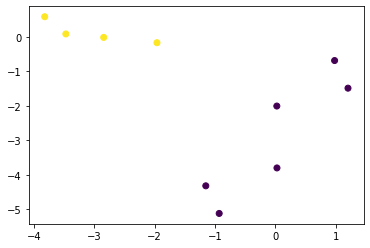

tensor(0.0904, grad_fn=<NllLossBackward>)


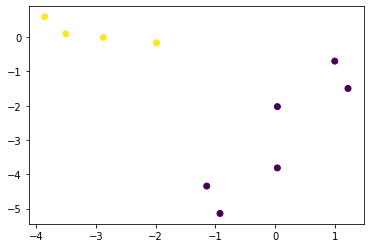

tensor(0.0877, grad_fn=<NllLossBackward>)


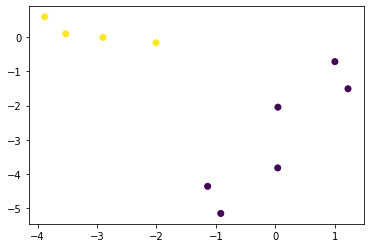

tensor(0.0851, grad_fn=<NllLossBackward>)


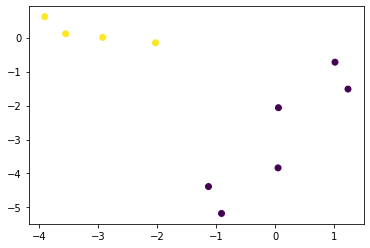

tensor(0.0827, grad_fn=<NllLossBackward>)


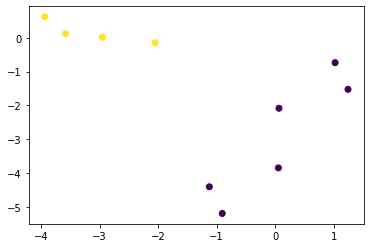

tensor(0.0803, grad_fn=<NllLossBackward>)


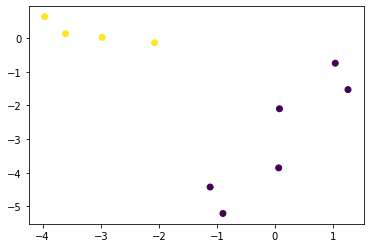

tensor(0.0781, grad_fn=<NllLossBackward>)


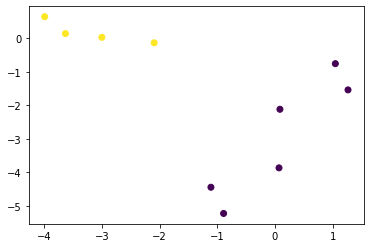

tensor(0.0759, grad_fn=<NllLossBackward>)


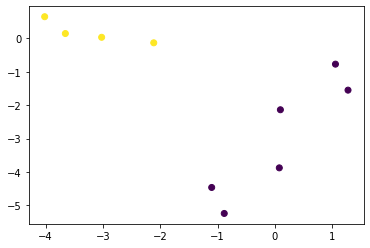

tensor(0.0739, grad_fn=<NllLossBackward>)


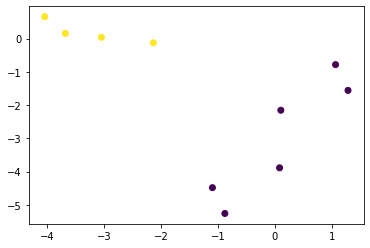

tensor(0.0719, grad_fn=<NllLossBackward>)


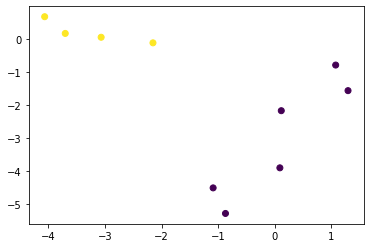

tensor(0.0700, grad_fn=<NllLossBackward>)


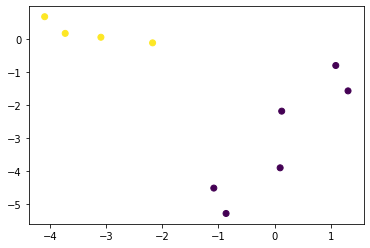

tensor(0.0682, grad_fn=<NllLossBackward>)


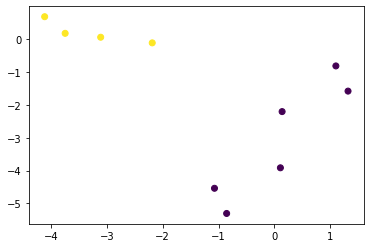

tensor(0.0665, grad_fn=<NllLossBackward>)


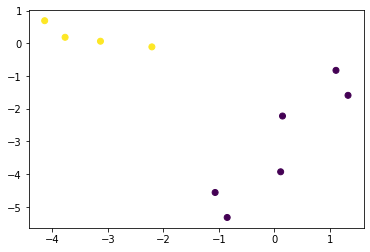

tensor(0.0648, grad_fn=<NllLossBackward>)


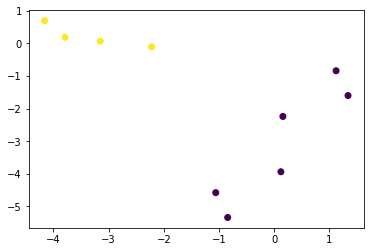

tensor(0.0632, grad_fn=<NllLossBackward>)


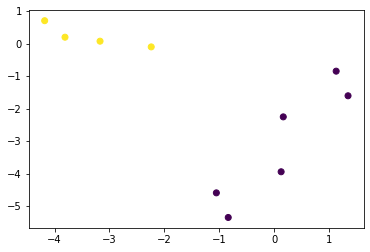

tensor(0.0617, grad_fn=<NllLossBackward>)


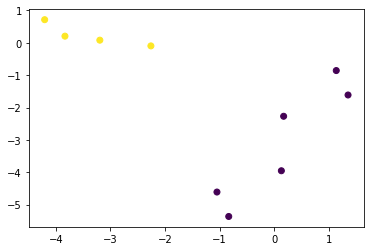

tensor(0.0602, grad_fn=<NllLossBackward>)


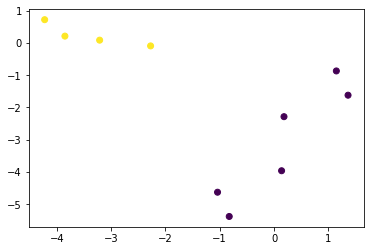

tensor(0.0588, grad_fn=<NllLossBackward>)


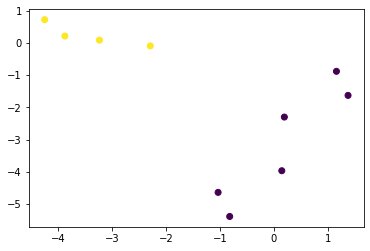

tensor(0.0574, grad_fn=<NllLossBackward>)


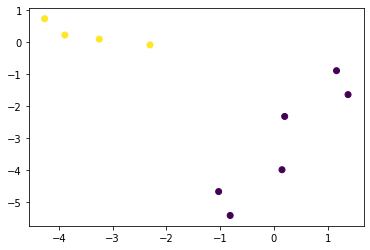

tensor(0.0561, grad_fn=<NllLossBackward>)


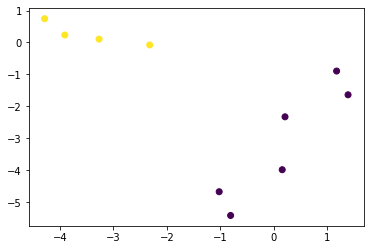

tensor(0.0549, grad_fn=<NllLossBackward>)


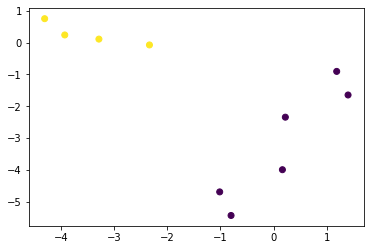

tensor(0.0536, grad_fn=<NllLossBackward>)


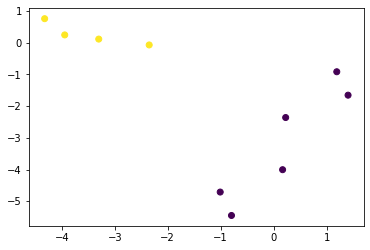

tensor(0.0525, grad_fn=<NllLossBackward>)


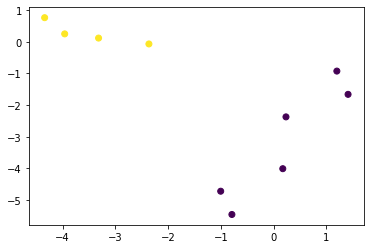

tensor(0.0513, grad_fn=<NllLossBackward>)


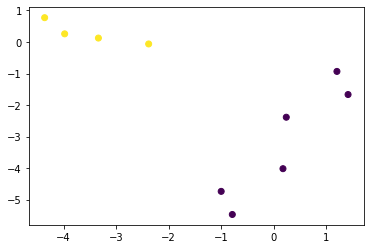

tensor(0.0502, grad_fn=<NllLossBackward>)


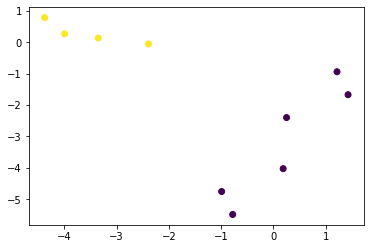

tensor(0.0492, grad_fn=<NllLossBackward>)


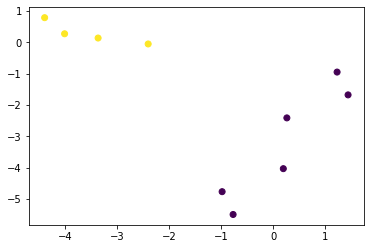

tensor(0.0482, grad_fn=<NllLossBackward>)


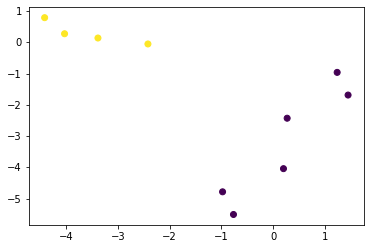

tensor(0.0472, grad_fn=<NllLossBackward>)


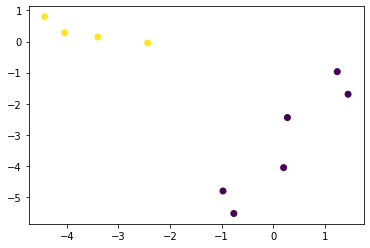

tensor(0.0462, grad_fn=<NllLossBackward>)


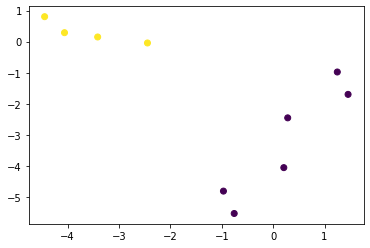

tensor(0.0453, grad_fn=<NllLossBackward>)


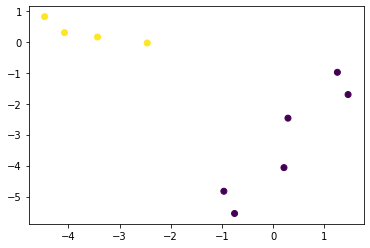

tensor(0.0444, grad_fn=<NllLossBackward>)


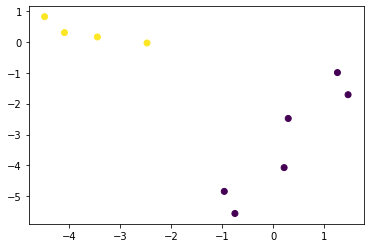

tensor(0.0436, grad_fn=<NllLossBackward>)


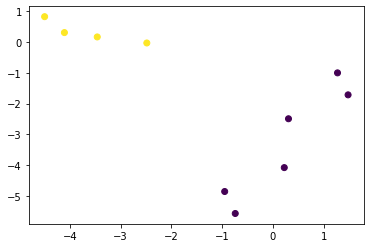

tensor(0.0427, grad_fn=<NllLossBackward>)


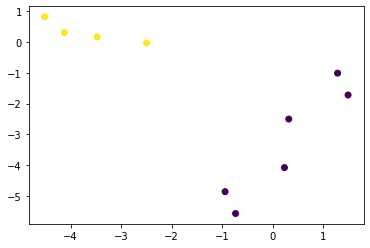

tensor(0.0419, grad_fn=<NllLossBackward>)


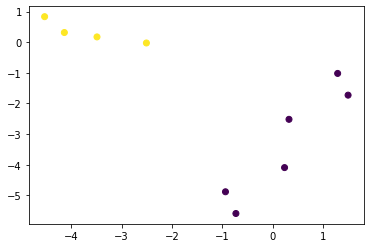

tensor(0.0411, grad_fn=<NllLossBackward>)


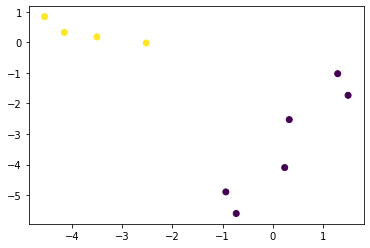

tensor(0.0404, grad_fn=<NllLossBackward>)


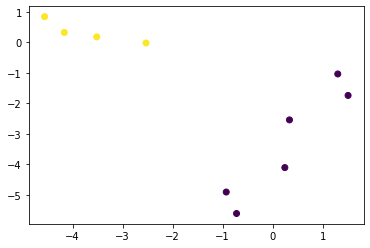

tensor(0.0397, grad_fn=<NllLossBackward>)


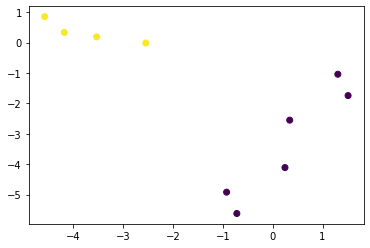

tensor(0.0389, grad_fn=<NllLossBackward>)


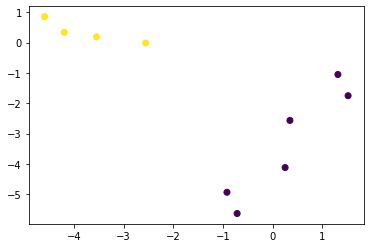

tensor(0.0382, grad_fn=<NllLossBackward>)


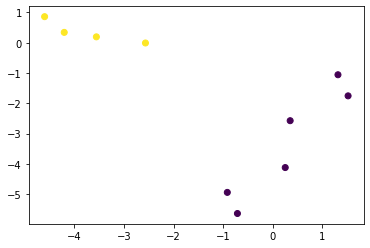

tensor(0.0376, grad_fn=<NllLossBackward>)


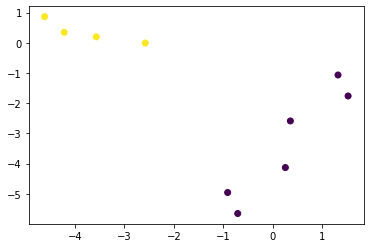

tensor(0.0369, grad_fn=<NllLossBackward>)


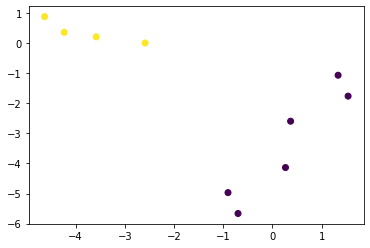

tensor(0.0363, grad_fn=<NllLossBackward>)


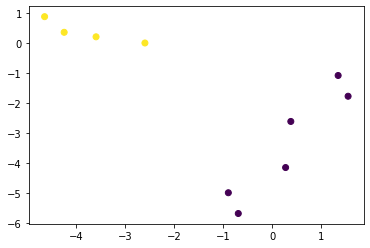

tensor(0.0357, grad_fn=<NllLossBackward>)


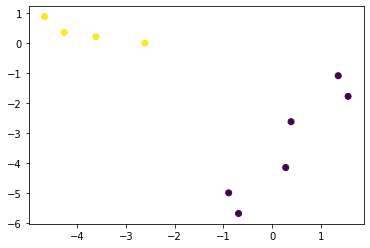

tensor(0.0351, grad_fn=<NllLossBackward>)


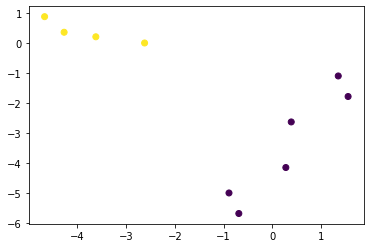

tensor(0.0345, grad_fn=<NllLossBackward>)


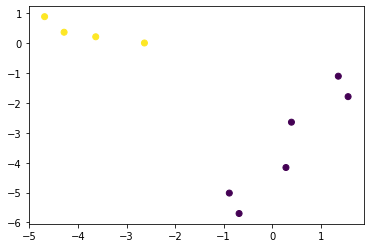

tensor(0.0339, grad_fn=<NllLossBackward>)


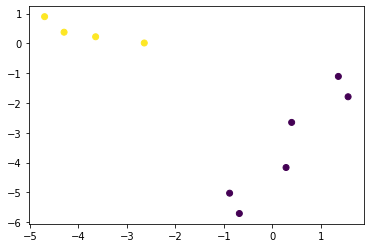

tensor(0.0334, grad_fn=<NllLossBackward>)


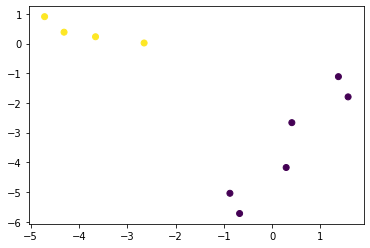

tensor(0.0328, grad_fn=<NllLossBackward>)


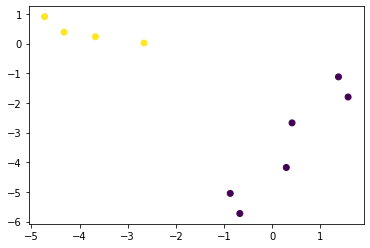

tensor(0.0323, grad_fn=<NllLossBackward>)


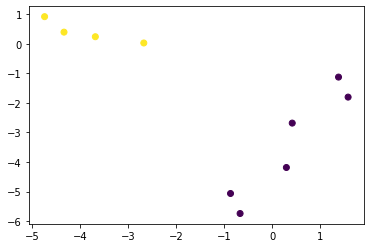

tensor(0.0318, grad_fn=<NllLossBackward>)


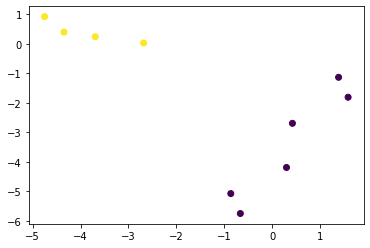

tensor(0.0313, grad_fn=<NllLossBackward>)


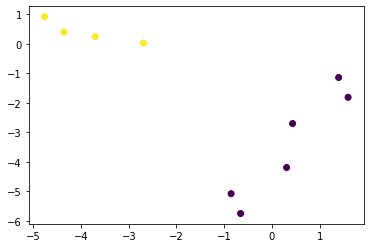

tensor(0.0308, grad_fn=<NllLossBackward>)


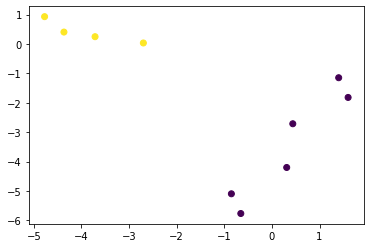

tensor(0.0304, grad_fn=<NllLossBackward>)


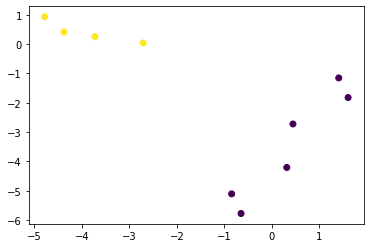

tensor(0.0299, grad_fn=<NllLossBackward>)


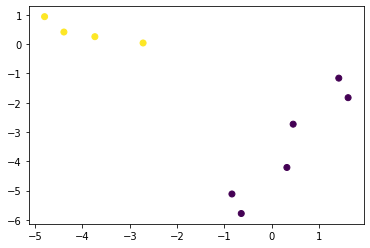

tensor(0.0295, grad_fn=<NllLossBackward>)


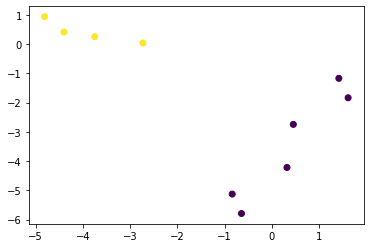

tensor(0.0290, grad_fn=<NllLossBackward>)


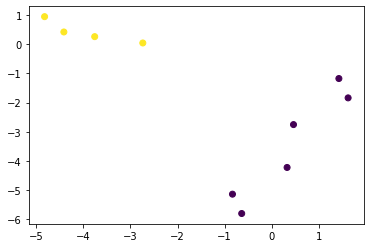

tensor(0.0286, grad_fn=<NllLossBackward>)


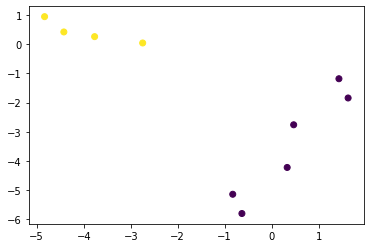

tensor(0.0282, grad_fn=<NllLossBackward>)


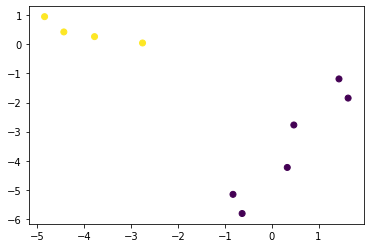

tensor(0.0278, grad_fn=<NllLossBackward>)


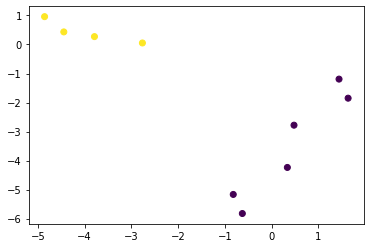

tensor(0.0274, grad_fn=<NllLossBackward>)


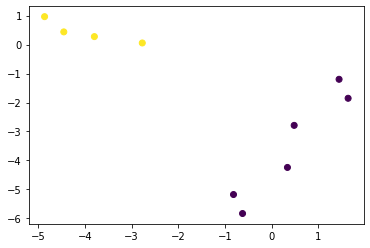

tensor(0.0270, grad_fn=<NllLossBackward>)


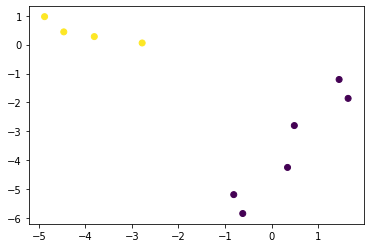

tensor(0.0266, grad_fn=<NllLossBackward>)


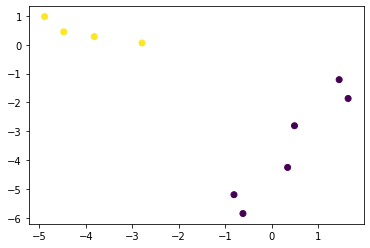

tensor(0.0263, grad_fn=<NllLossBackward>)


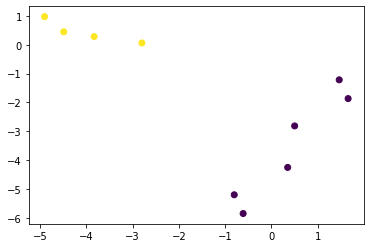

tensor(0.0259, grad_fn=<NllLossBackward>)


In [13]:
for i in range(10000):
    optimizer.zero_grad()
    loss=criterion(T(), target)
    loss.backward()
    optimizer.step()
    l=(T());
    if i%100==0:
        plt.scatter(l.detach().numpy()[:,0],l.detach().numpy()[:,1],c=[1,1,1,1, 0, 0, 0, 0, 0, 0])
        plt.show()
        print(loss)

In [14]:
print(torch.softmax(T(),dim=1))

tensor([[0.0159, 0.9841],
        [0.0028, 0.9972],
        [0.0536, 0.9464],
        [0.0070, 0.9930],
        [0.9880, 0.0120],
        [0.9948, 0.0052],
        [0.9902, 0.0098],
        [0.9715, 0.0285],
        [0.9364, 0.0636],
        [0.9655, 0.0345]], grad_fn=<SoftmaxBackward>)


In [15]:
loss=criterion(T(),target)

In [16]:
print(target[mask])

tensor([-1,  1,  1,  1,  1,  1,  1,  1,  1, -1])


In [17]:
mask

tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 1])

In [18]:
torch.set_printoptions(threshold=5000)

In [19]:
print(loss)

tensor(0.0256, grad_fn=<NllLossBackward>)
